<a href="https://colab.research.google.com/github/Expert-Han/Nonlinear_Model_Predictive_Control_Python_byHan/blob/main/NMPC230224Final_Fail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://mintoc.de/index.php/Three_Tank_multimode_problem_(python/casadi)

## Python version check & Casadi install in Colab

In [4]:
!python --version 

Python 3.8.10


In [5]:
pip install casadi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 42.3 MB/s eta 0:00:00


In [6]:
from casadi import *
# x = MX.sym("x")
# print(jacobian(sin(x),x))

x1 = SX.sym('x1',1)
x2 = SX.sym('x2',1)
x = [x1, x2]
y = SX.sym('y')
f = Function('f',[x1,x2],[x1,x2])
print(f)

f:(i0,i1)->(o0,o1) SXFunction


## Main code for NMPC (Nonlinear Model Predictive Control)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1904
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:     1310

Total number of variables............................:      504
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      404
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

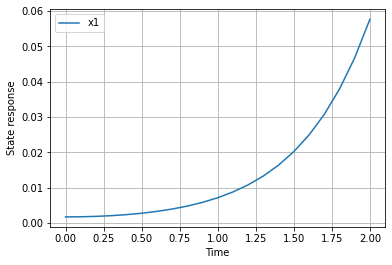

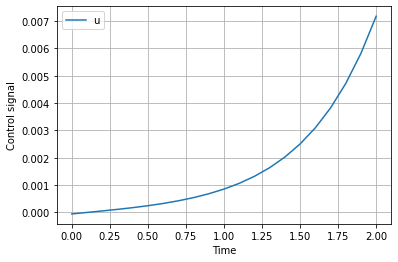

In [85]:
import numpy as np
from matplotlib import pyplot as plt
global M, m, L, g, im, N, tn, P
M = 0.5       # mass of the cart (kg)  
m = 0.5       # mass of the pendulum bob (kg)
L = 1         # length of the pendulum rod (m)
g = 9.81      # gravity
im = 0.5      # inertia  
ti = 0.1 # RK45 sampling time
N = 10 # Prediction horizon
tn = N/ti
## Predict u code 
P = np.array([[131.6360,   72.5719,   -9.3300,  -18.6034],[72.5719,   42.5803,   -5.2196,  -10.8740],[-9.3300,   -5.2196,    1.2303,    1.4100],[-18.6034,  -10.8740,    1.4100,    3.2027]])

def solve_CFTOCP(x_t, N, Q, R, ti):
  # Inverted Pendulum
  f = lambda x,u: vertcat(x[1], (-m**2*(L/2)**2*np.sin(x[0])*np.cos(x[0])*x[1]**2+(M+m)*m*g*(L/2)*np.sin(x[0])+m*(L/2)*np.cos(x[0])*u)/((M+m)*(im+m*(L/2)**2)-m**2*(L/2)**2*np.cos(x[0])**2),x[3],(m**2*(L/2)**2*np.sin(x[0])*np.cos(x[0])*g-m*(im+m*(L/2)**2)*(L/2)*np.sin(x[0])*x[1]**2+(im+m*(L/2)**2)*u)/((M+m)*(im+m*(L/2)**2)-m**2*(L/2)**2*np.cos(x[0])**2))
  opti = casadi.Opti()
  # Prediction Size N
  x = opti.variable(4,int(tn+1)) # Decision variables for state trajetcory, tn + next_state
  u = opti.variable(1,int(tn))
  p = opti.parameter(4,1)  # Parameter (not optimized over) <=> updated initial state

  opti.subject_to(x[:,1]==p)
  opti.subject_to(dot(x[:,int(tn)],P@x[:,int(tn)]) <= 0.0000001)  # Final constraint

  for k in range(0, int(tn)): # loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(x[:,k],         u[:,k])
    k2 = f(x[:,k]+ti/2*k1, u[:,k])
    k3 = f(x[:,k]+ti/2*k2, u[:,k])
    k4 = f(x[:,k]+ti*k3,   u[:,k])
    x_next = x[:,k] + ti/6*(k1+2*k2+2*k3+k4) 
    opti.subject_to(x[:,k+1]==x_next) # close the gaps
  
  # for k in range(0, int(tn+1)):
  #   opti.subject_to(x[0,k] <= 10) # The first state is bounded by 1
  #   opti.subject_to(x[0,k] >= -10) # The first state is bounded by 1

  # for k in range(0, int(tn)):
  #   opti.subject_to(u[0,k] <= 10)  # The first input is bounded by 10
  #   opti.subject_to(u[0,k] >= -10)  # The first input is bounded by 10

  # Cost
  Cost=0
 
  for k in range(0, int(tn)):
    # Cost = Cost + x[:,k].T*Q*x[:,k] + u[:,k].T*R*u[:,k] 
    Cost = Cost + dot(x[:,k],Q@x[:,k]) + dot(u[:,k],R@u[:,k])
  Cost = Cost + dot(x[:,tn],Q@x[:,tn]) + dot(x[:,tn],P@x[:,tn]) # Add final state

  # Solve
  opti.minimize(Cost)
  opti.set_value(p,x_t)
  opti.solver("ipopt") # set numerical backend
  sol = opti.solve()   # actual solve

  x = sol.value(x)
  u = sol.value(u)
  print(sol.value(Cost))

  # x = double(x)
  # u = double(u)
  uPred = u[0]

  return uPred

## Simulation Code
a = 0.1
Q = np.array([[a, 0, 0, 0],[0, a, 0, 0],[0, 0, a, 0],[0, 0, 0, a]]) # weighting matrix for state
R = np.array([0.1]) # weighting matrix for input

x = MX.sym('x',4) # States define
u  = MX.sym('u') # Controls

# Inverted Pendulum
# Initialize simulation parameters
i = 0    
degree = 0.1
x0 = np.array([degree*(np.pi)/180, 0, 0, 0], dtype=np.float64) 
# x0 = np.array([0.01, 0, 0, 0], dtype=np.float64) 
x_sig = np.array([x0], dtype=np.float64)
# uPred = solve_CFTOCP(x_sig[i], N, Q, R, ti)
# u_sig = np.array([uPred], dtype=np.float64)
u_sig = np.array([0], dtype=np.float64)

tf = 2
sam = int(tf / ti)
tspan = np.linspace(0, tf, sam + 1)
xs = len(tspan)

# for i in range(0, xs - 1):
#   uPred = solve_CFTOCP(x_sig[i], N, Q, R, ti)
#   dx = rk(x0=x_sig[i],p=uPred)
#   x_sig = np.vstack((x_sig,dx['xf'].full().T))
#   if i >= 1:
#     u_sig = np.vstack((u_sig,uPred))
#   print('================================Time======================================')
#   print(i)

f = lambda x,u: vertcat(x[1], (-m**2*(L/2)**2*np.sin(x[0])*np.cos(x[0])*x[1]**2+(M+m)*m*g*(L/2)*np.sin(x[0])+m*(L/2)*np.cos(x[0])*u)/((M+m)*(im+m*(L/2)**2)-m**2*(L/2)**2*np.cos(x[0])**2),x[3],(m**2*(L/2)**2*np.sin(x[0])*np.cos(x[0])*g-m*(im+m*(L/2)**2)*(L/2)*np.sin(x[0])*x[1]**2+(im+m*(L/2)**2)*u)/((M+m)*(im+m*(L/2)**2)-m**2*(L/2)**2*np.cos(x[0])**2))

# for i in range(0, xs - 1):
#   # Runge-Kutta 4 integration
#   uPred = solve_CFTOCP(x_sig[i], N, Q, R, ti)
#   k1 = f(x_sig[i],         uPred)
#   k2 = f(x_sig[i]+ti/2*k1, uPred)
#   k3 = f(x_sig[i]+ti/2*k2, uPred)
#   k4 = f(x_sig[i]+ti*k3,   uPred)
#   x_next = x_sig[i] + ti/6*(k1+2*k2+2*k3+k4) 
#   x_sig = np.vstack((x_sig,x_next.T))
#   if i >= 1:
#     u_sig = np.vstack((u_sig,uPred))
#   print('================================Time======================================')
#   print(i)
#   print(x_sig[i, :])
K = np.array([-56.2839,-28.3492,2.5110,6.9588])
for i in range(0, xs - 1):
  # Runge-Kutta 4 integration
  uPred = solve_CFTOCP(x_sig[i], N, Q, R, ti)
  k1 = f(x_sig[i],         uPred)
  k2 = f(x_sig[i]+ti/2*k1, uPred)
  k3 = f(x_sig[i]+ti/2*k2, uPred)
  k4 = f(x_sig[i]+ti*k3,   uPred)
  x_next = x_sig[i] + ti/6*(k1+2*k2+2*k3+k4) 
  x_sig = np.vstack((x_sig,x_next.T))
  u_sig = np.vstack((u_sig,uPred))
  
  print('================================Time======================================')
  print(i)
uPred = solve_CFTOCP(x_sig[i+1], N, Q, R, ti)
u_sig = np.vstack((u_sig,uPred))
u_sig = u_sig.tolist()
del u_sig[0]
u_sig = np.array(u_sig)


plt.figure()
plt.plot(tspan, x_sig[:, 0], label="x1")
# plt.plot(tspan, x_sig[:, 1], label="x2")
# plt.plot(tspan, x_sig[:, 2], label="x3")
# plt.plot(tspan, x_sig[:, 3], label="x4")
plt.grid()
plt.xlabel("Time")
plt.ylabel("State response")
plt.legend()
plt.show()

plt.figure()
plt.plot(tspan, u_sig[:, 0], label="u")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Control signal")
plt.legend()
plt.show()